In [1]:
from interarray.importer import load_repository
from interarray.svg import svgplot
from interarray.mesh import make_planar_embedding
from interarray.interarraylib import G_from_S
from interarray.heuristics import EW_presolver
from interarray.MILP import pyomo as omo
from interarray.pathfinding import PathFinder

In [2]:
from pyomo import environ as pyo

## Initialize MILP solver

In [3]:
cbcer = pyo.SolverFactory('cbc')
cbcer.available(), type(cbcer)

(True, pyomo.solvers.plugins.solvers.CBCplugin.CBCSHELL)

## Load interarray's locations

In [4]:
locations = load_repository()

## Optimize Walney Extension

In [5]:
L = locations.walneyext
capacity = 5

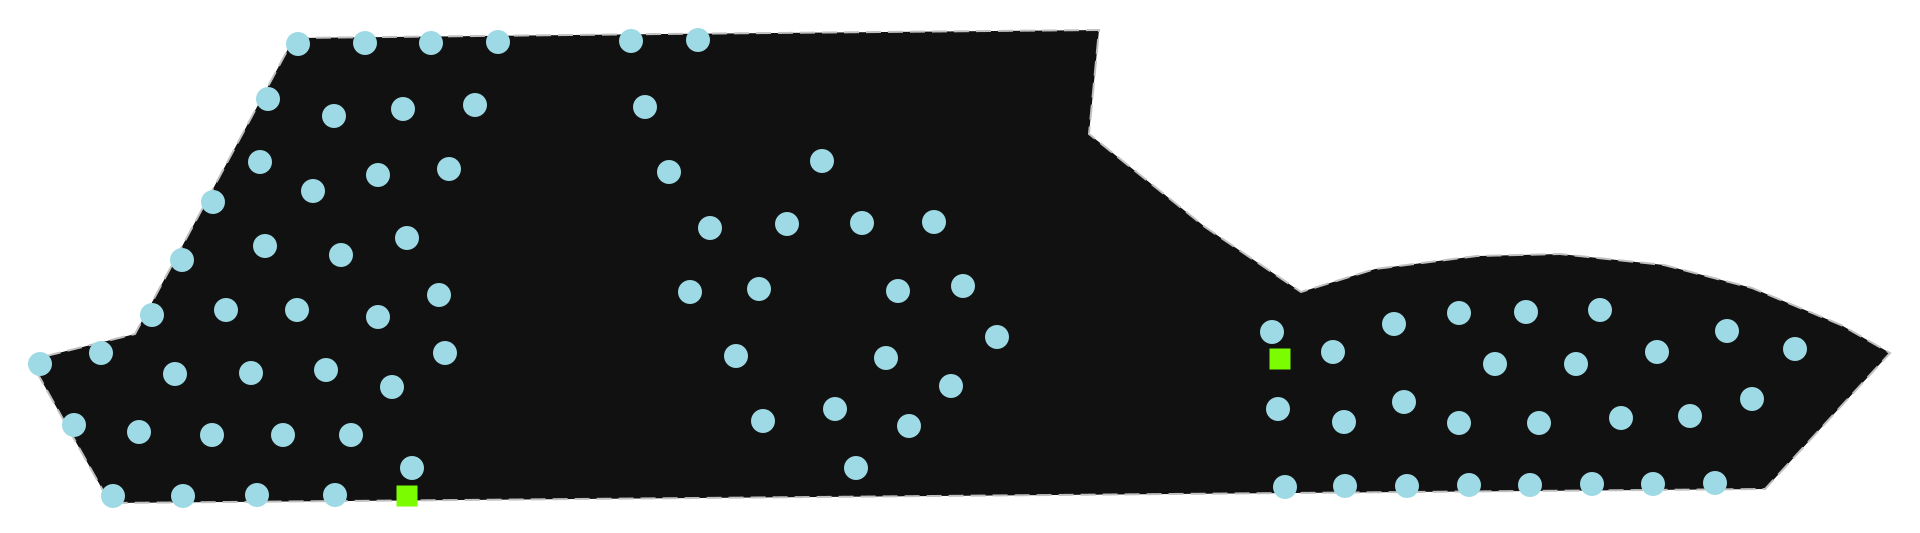

In [6]:
svgplot(L)

In [7]:
P, A = make_planar_embedding(L)

Initial heuristic solution to warm-start the solver:

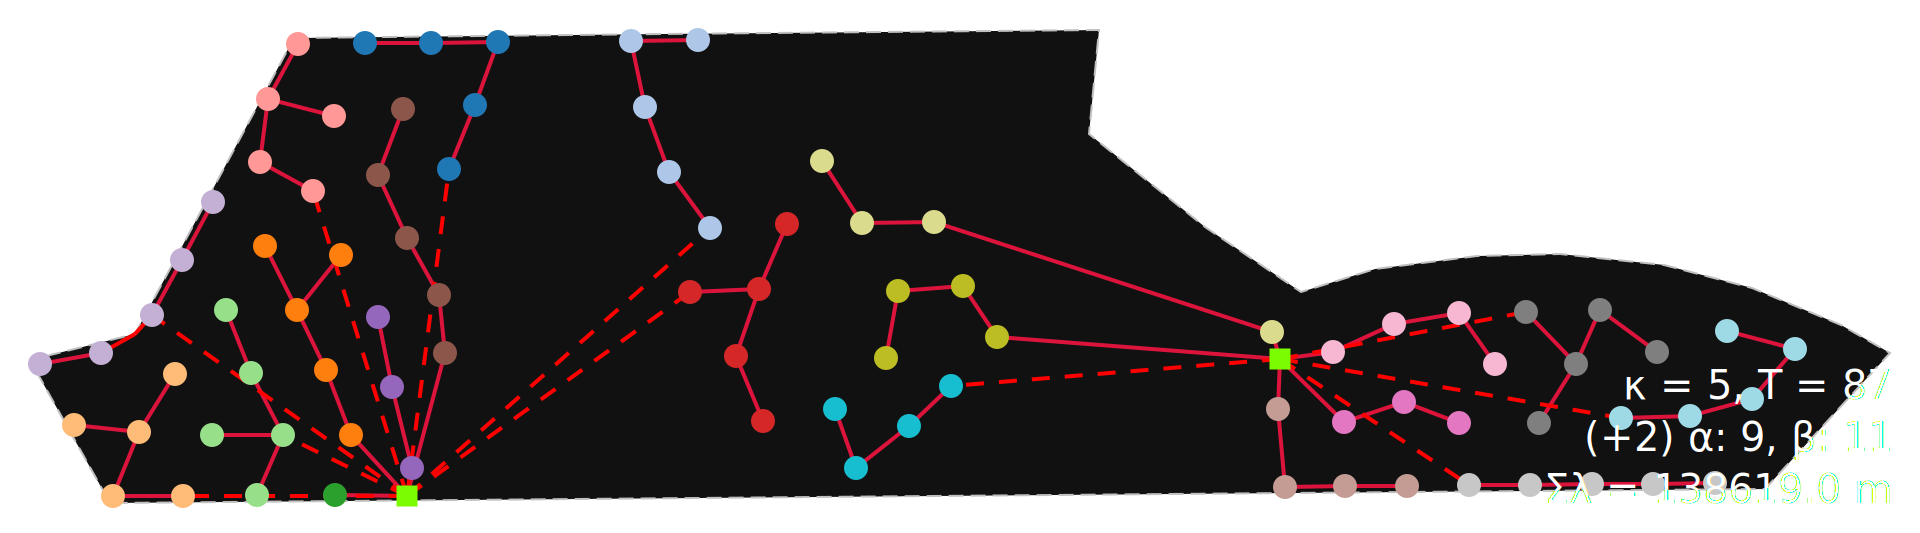

In [8]:
Sʹ = EW_presolver(A, capacity=capacity)
Gʹ = G_from_S(Sʹ, A)
svgplot(Gʹ)

In [9]:
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(model, Sʹ);

In [10]:
cbcer = pyo.SolverFactory('cbc')
cbcer.available(), type(cbcer)

(True, pyomo.solvers.plugins.solvers.CBCplugin.CBCSHELL)

In [11]:
cbcer.options.update(dict(
    ratioGap=0.005,
    seconds=150,
    timeMode='elapsed',
    threads=8,
    # if repeatable results are desired, set the seed
    RandomCbcSeed=4321,
    # the parameters below and more can be experimented with
    # http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf
    nodeStrategy='downFewest',
    # Heuristics
    Dins='on',
    VndVariableNeighborhoodSearch='on',
    Rens='on',
    Rins='on',
    pivotAndComplement='off',
    proximitySearch='off',
    # Cuts
    gomoryCuts='on',
    mixedIntegerRoundingCuts='on',
    flowCoverCuts='on',
    cliqueCuts='off',
    twoMirCuts='off',
    knapsackCuts='off',
    probingCuts='off',
    zeroHalfCuts='off',
    liftAndProjectCuts='off',
    residualCapacityCuts='off',
))
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
result = cbcer.solve(model, warmstart=model.warmed_by, tee=True)

Solving "walneyext": {R=2, T=87, k=5}

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - C:\Users\s213184\programs\cbc_julia_mingw32_2.10.8\bin\cbc.exe -ratioGap 0.005 -seconds 150 -timeMode elapsed -threads 8 -RandomCbcSeed 4321 -nodeStrategy downFewest -Dins on -VndVariableNeighborhoodSearch on -Rens on -Rins on -pivotAndComplement off -proximitySearch off -gomoryCuts on -mixedIntegerRoundingCuts on -flowCoverCuts on -cliqueCuts off -twoMirCuts off -knapsackCuts off -probingCuts off -zeroHalfCuts off -liftAndProjectCuts off -residualCapacityCuts off -printingOptions all -import C:\Users\s213184\AppData\Local\Temp\tmpbgy3p072.pyomo.lp -mipstart \Users\s213184\AppData\Local\Temp\tmpojd9i_9a.cbc.soln -stat=1 -solve -solu C:\Users\s213184\AppData\Local\Temp\tmpbgy3p072.pyomo.soln (default strategy 1)
ratioGap was changed from 0 to 0.005
seconds was changed from 1e+100 to 150
Option for timeMode changed from cpu to elapsed
threads was changed from 0

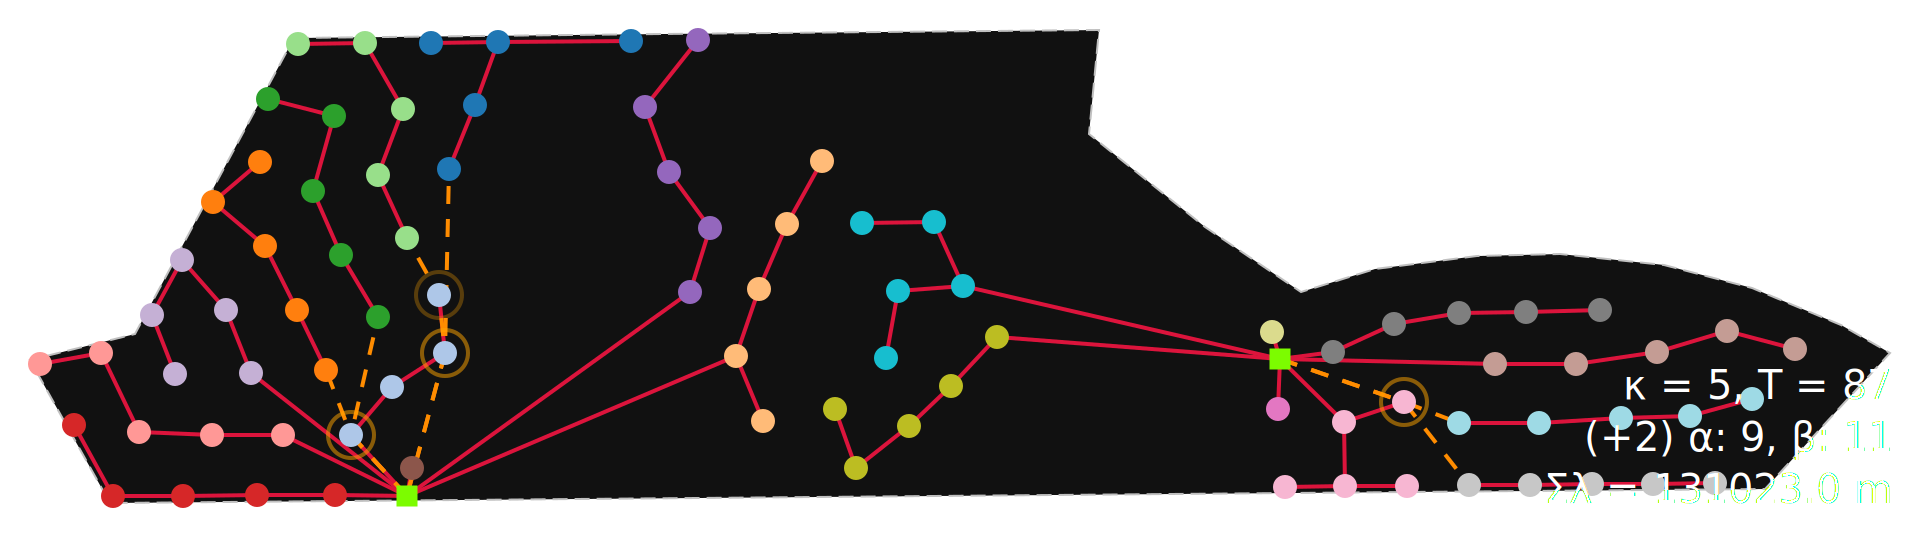

In [12]:
S = omo.S_from_solution(model, cbcer, result)
G = G_from_S(S, A)
H = PathFinder(G, planar=P, A=A).create_detours()
svgplot(H)